In [35]:
from __future__ import absolute_import
from sage.graphs.connectivity import TriconnectivitySPQR
from sage.graphs.connectivity import spqr_tree_to_graph
from sage.graphs.graph_latex import check_tkz_graph
from sage.graphs.graph import Graph
from sage.rings.integer import Integer

In [36]:
from operator import itemgetter
import pandas as pd
import itertools
import os
import networkx as nx
from networkx.drawing.nx_pydot import to_pydot
from graphviz import Source
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [37]:
class _LinkedListNode:

	def __init__(self, data=None):

		self.data = data
		self.prev = None
		self.next = None
		self.set_data(self.data)

	def set_data(self, data):
		self.data = data

	def get_data(self):
		return self.data

In [38]:
class _LinkedList:

	def __init__(self):

		self.head = None
		self.tail = None
		self.length = 0

	def remove(self, node):

		if node.prev is None and node.next is None:
			self.head = None
			self.tail = None
		elif node.prev is None:
			self.head = node.next
			node.next.prev = None
		elif node.next is None:
			node.prev.next = None
			self.tail = node.prev
		else:
			node.prev.next = node.next
			node.next.prev = node.prev
		self.length -= 1

	def set_head(self, h):

		self.head = h
		self.tail = h
		self.length = 1

	def append(self, node):

		if self.head is None:
			self.set_head(node)
		else:
			self.tail.next = node
			node.prev = self.tail
			self.tail = node
			self.length += 1

	def get_head(self):
		return self.head

	def get_length(self):
		return self.length

	def push_front(self, node):

		if self.head is None:
			self.set_head(node)
		else:
			self.head.prev = node
			node.next = self.head
			self.head = node
			self.length += 1

	def to_string(self):

		temp = self.head
		s = ""
		while temp:
			s += "  " + str(temp.get_data())
			temp = temp.next
		return s

	def concatenate(self, lst2):

		self.tail.next = lst2.head
		lst2.head.prev = self.tail
		self.tail = lst2.tail
		self.length += lst2.length
		lst2.head = None
		lst2.length = 0

In [39]:
class _Component:

	def __init__(self, edge_list, type_c):

		self.edge_list = _LinkedList()
		for e in edge_list:
			self.add_edge(e)
		self.component_type = type_c

	def add_edge(self, e):
		self.edge_list.append(_LinkedListNode(e))

	def finish_tric_or_poly(self, e):

		self.add_edge(e)
		if self.edge_list.get_length() > 3:
			self.component_type = 2
		else:
			self.component_type = 1

	def __str__(self):

		if self.component_type == 0:
			type_str = "Bond: "
		elif self.component_type == 1:
			type_str =  "Polygon: "
		else:
			type_str = "Triconnected: "
		return type_str + self.edge_list.to_string()

	def get_edge_list(self):

		e_list = []
		e_node = self.edge_list.get_head()
		while e_node:
			e_list.append(e_node.get_data())
			e_node = e_node.next
		return e_list

In [40]:
class TriconnectivitySPQR:

	def __init__(self, G, check=True):

		self.n = G.order()
		self.m = G.size()
		self.graph_name = G.name()


		if self.n < 2:
			raise ValueError("Grafo no es biconexo")
		elif self.n == 2 and self.m:

			self.comp_list_new = [G.edges()]
			self.comp_type = [0]
			self.__build_spqr_tree()
			return
		elif self.m < self.n -1:

			raise ValueError("Grafo no es conexo")
		elif self.m < self.n:

			raise ValueError("Grafo no es biconexo")

		self.int_to_vertex = G.vertices()
		self.vertex_to_int = {u:i for i,u in enumerate(self.int_to_vertex)}
		self.int_to_original_edge_label = []
		self.graph_copy = Graph(self.n, multiedges=True)
		for i,(u, v, l) in enumerate(G.edge_iterator()):
			self.graph_copy.add_edge(self.vertex_to_int[u], self.vertex_to_int[v], i)
			self.int_to_original_edge_label.append(l)


		self.edge_status = {e: 0 for e in self.graph_copy.edge_iterator()}


		self.reverse_edges = set()

		self.dfs_number = [0 for i in range(self.n+1)]


		self.highpt = [_LinkedList() for i in range(self.n)]


		self.in_high = {e:None for e in self.graph_copy.edge_iterator()}


		self.old_to_new = [0 for i in range(self.n+1)]
		self.newnum = [0 for i in range(self.n)]
		self.node_at = [0 for i in range(self.n+1)]
		self.lowpt1 = [None for i in range(self.n)]
		self.lowpt2 = [None for i in range(self.n)]


		self.adj = [_LinkedList() for i in range(self.n)]


		self.in_adj = {}
		self.nd = [None for i in range(self.n)]


		self.parent = [None for i in range(self.n)]
		self.degree = [None for i in range(self.n)]
		self.tree_arc = [None for i in range(self.n)]
		self.vertex_at = [1 for i in range(self.n)]
		self.dfs_counter = 0
		self.components_list = []
		self.graph_copy_adjacency = [[] for i in range(self.n)]


		self.starts_path = {e:False for e in self.graph_copy.edge_iterator()}

		self.is_biconnected = True
		self.cut_vertex = None


		self.virtual_edge_num = 0

		self.virtual_edges = set()

		self.new_path = False


		self.e_stack = []
		self.t_stack_h = [None for i in range(2*self.m + 1)]
		self.t_stack_a = [None for i in range(2*self.m + 1)]
		self.t_stack_b = [None for i in range(2*self.m + 1)]
		self.t_stack_top = 0
		self.t_stack_a[self.t_stack_top] = -1


		self.comp_list_new = []
		self.comp_type = []

		self.spqr_tree = None

		self.type1 = []
		self.type2 = []

		for e in self.graph_copy.edge_iterator():
			self.graph_copy_adjacency[e[0]].append(e)
			self.graph_copy_adjacency[e[1]].append(e)

		self.dfs_counter = 0
		self.start_vertex = 0
		self.cut_vertex = self.__dfs1(self.start_vertex, check=check)

		if check:

			if self.dfs_counter < self.n:
				raise ValueError("Graph is not connected")

			if self.cut_vertex is not None:
				raise ValueError("Graph has a cut vertex")


		for e in self.graph_copy.edge_iterator():
			up = (self.dfs_number[e[1]] - self.dfs_number[e[0]]) > 0
			if (up and self.edge_status[e]==2) or (not up and self.edge_status[e]==1):

				self.reverse_edges.add(e)

		self.__build_acceptable_adj_struct()
		self.__dfs2()

		self.__path_search(self.start_vertex)

		if self.e_stack:
			e = self.__estack_pop()
			c = _Component(self.e_stack, 0)
			c.finish_tric_or_poly(e)
			self.components_list.append(c)

		self.__print_split()
		self.__assemble_triconnected_components()

		self.__build_spqr_tree()

	def __tstack_push(self, h, a, b):

		self.t_stack_top += 1
		self.t_stack_h[self.t_stack_top] = h
		self.t_stack_a[self.t_stack_top] = a
		self.t_stack_b[self.t_stack_top] = b

	def __tstack_push_eos(self):

		self.t_stack_top += 1
		self.t_stack_a[self.t_stack_top] = -1

	def __tstack_not_eos(self):

		return self.t_stack_a[self.t_stack_top] != -1

	def __tstack_print(self):

		return self.t_stack_a, self.t_stack_b, self.t_stack_h

	def __estack_pop(self):

		return self.e_stack.pop()

	def __estack_print(self):

		return self.e_stack

	def __new_component(self, edges=[], type_c=0):

		c = _Component(edges, type_c)
		self.components_list.append(c)
		return c

	def __new_virtual_edge(self, u, v):

		e = (u, v, "newVEdge"+str(self.virtual_edge_num))
		self.virtual_edge_num += 1
		self.virtual_edges.add(e)
		return e

	def __high(self, v):

		head = self.highpt[v].get_head()
		if head is None:
			return 0
		else:
			return head.get_data()

	def __del_high(self, e):

		if e in self.in_high:
			it = self.in_high[e]
			if it:
				if e in self.reverse_edges:
					v = e[0]
				else:
					v = e[1]
				self.highpt[v].remove(it)

	def __bucket_sort(self, bucket, edge_list):

		if len(bucket) == 1:
			return

		bucket_list = []
		for i in range(self.n):
			bucket_list.append(_LinkedList())

		e_node = edge_list.head

		# Link the n buckets w.r.t bucketId
		while e_node:
			bucketId = bucket[e_node.get_data()]
			if bucket_list[bucketId].get_head():
				bucket_list[bucketId].tail.next = e_node
				bucket_list[bucketId].tail = bucket_list[bucketId].tail.next
			else:
				bucket_list[bucketId].set_head(e_node)
			e_node = e_node.next

		# Rearrange the `edge_list` Using bucket list
		new_tail = None
		for i in range(self.n):
			new_head = bucket_list[i].get_head()
			if new_head:
				if new_tail:
					new_tail.next = new_head
				else:
					edge_list.set_head(new_head)
				new_tail = bucket_list[i].tail

		edge_list.tail = new_tail
		new_tail.next = None

	def __sort_edges(self):


		edge_list = _LinkedList()
		for e in self.graph_copy.edges(sort=False):
			edge_list.append(_LinkedListNode(e))

		bucketMin = {}
		bucketMax = {}

		for e in self.graph_copy.edge_iterator():
			bucketMin[e] = e[0]
			bucketMax[e] = e[1]

		self.__bucket_sort(bucketMin, edge_list)
		self.__bucket_sort(bucketMax, edge_list)

		return edge_list.get_head()

	def __dfs1(self, v, u=None, check=True):

		first_son = None
		s1 = None
		self.dfs_counter += 1
		self.dfs_number[v] = self.dfs_counter
		self.parent[v] = u
		self.degree[v] = self.graph_copy.degree(v)
		self.lowpt1[v] = self.lowpt2[v] = self.dfs_number[v]
		self.nd[v] = 1
		for e in self.graph_copy_adjacency[v]:
			if self.edge_status[e]:
				continue

			w = e[0] if e[0] != v else e[1]
			if self.dfs_number[w] == 0:
				self.edge_status[e] = 1
				if first_son is None:
					first_son = w
				self.tree_arc[w] = e
				s1 = self.__dfs1(w, v, check)

				if check:

					if (self.lowpt1[w] >= self.dfs_number[v]) and (w != first_son or u != None):
						s1 = v

				if self.lowpt1[w] < self.lowpt1[v]:
					self.lowpt2[v] = min(self.lowpt1[v], self.lowpt2[w])
					self.lowpt1[v] = self.lowpt1[w]

				elif self.lowpt1[w] == self.lowpt1[v]:
					self.lowpt2[v] = min(self.lowpt2[v], self.lowpt2[w])

				else:
					self.lowpt2[v] = min(self.lowpt2[v], self.lowpt1[w])

				self.nd[v] += self.nd[w]

			else:
				self.edge_status[e] = 2
				if self.dfs_number[w] < self.lowpt1[v]:
					self.lowpt2[v] = self.lowpt1[v]
					self.lowpt1[v] = self.dfs_number[w]
				elif self.dfs_number[w] > self.lowpt1[v]:
					self.lowpt2[v] = min(self.lowpt2[v], self.dfs_number[w])

		return s1


	def __build_acceptable_adj_struct(self):

		max_size = 3*self.n + 2
		bucket = [[] for _ in range(max_size + 1)]

		for e in self.graph_copy.edge_iterator():
			edge_type = self.edge_status[e]

			if e in self.reverse_edges:
				if edge_type == 1:
					if self.lowpt2[e[0]] < self.dfs_number[e[1]]:
						phi = 3*self.lowpt1[e[0]]
					else:
						phi = 3*self.lowpt1[e[0]] + 2
				else:
					phi = 3*self.dfs_number[e[0]]+1
			else:
				if edge_type == 1:
					if self.lowpt2[e[1]] < self.dfs_number[e[0]]:
						phi = 3*self.lowpt1[e[1]]
					else:
						phi = 3*self.lowpt1[e[1]] + 2
				else:
					phi = 3*self.dfs_number[e[1]]+1

			bucket[phi].append(e)

		for i in range(1, max_size + 1):
			for e in bucket[i]:
				node = _LinkedListNode(e)
				if e in self.reverse_edges:
					self.adj[e[1]].append(node)
					self.in_adj[e] = node
				else:
					self.adj[e[0]].append(node)
					self.in_adj[e] = node

	def __path_finder(self, v):

		self.newnum[v] = self.dfs_counter - self.nd[v] + 1
		e_node = self.adj[v].get_head()
		while e_node:
			e = e_node.get_data()
			e_node = e_node.next
			w = e[1] if e[0] == v else e[0]
			if self.new_path:
				self.new_path = False
				self.starts_path[e] = True
			if self.edge_status[e] == 1:
				self.__path_finder(w)
				self.dfs_counter -= 1
			else:

				highpt_node = _LinkedListNode(self.newnum[v])
				self.highpt[w].append(highpt_node)
				self.in_high[e] = highpt_node
				self.new_path = True


	def __dfs2(self):

		self.in_high = {e:None for e in self.graph_copy.edge_iterator()}
		self.dfs_counter = self.n
		self.newnum = [0 for i in range(self.n)]
		self.starts_path = {e:False for e in self.graph_copy.edge_iterator()}

		self.new_path = True

		self.__path_finder(self.start_vertex)

		for v in self.graph_copy.vertex_iterator():
			self.old_to_new[self.dfs_number[v]] = self.newnum[v]

		for v in self.graph_copy.vertex_iterator():
			self.node_at[self.newnum[v]] = v
			self.lowpt1[v] = self.old_to_new[self.lowpt1[v]]
			self.lowpt2[v] = self.old_to_new[self.lowpt2[v]]

	def __path_search(self, v):

		y = 0
		vnum = self.newnum[v]
		outv = self.adj[v].get_length()
		e_node = self.adj[v].get_head()
		while e_node:
			e = e_node.get_data()
			it = e_node

			if e in self.reverse_edges:
				w = e[0]
			else:
				w = e[1]
			wnum = self.newnum[w]
			if self.edge_status[e] == 1:
				if self.starts_path[e]:
					y = 0

					if self.t_stack_a[self.t_stack_top] > self.lowpt1[w]:
						while self.t_stack_a[self.t_stack_top] > self.lowpt1[w]:
							y = max(y, self.t_stack_h[self.t_stack_top])
							b = self.t_stack_b[self.t_stack_top]
							self.t_stack_top -= 1
						self.__tstack_push(y, self.lowpt1[w], b)

					else:
						self.__tstack_push(wnum + self.nd[w] - 1, self.lowpt1[w], vnum)
					self.__tstack_push_eos()

				self.__path_search(w)

				self.e_stack.append(self.tree_arc[w])
				temp_node = self.adj[w].get_head()
				temp = temp_node.get_data()
				if temp in self.reverse_edges:
					temp_target = temp[0]
				else:
					temp_target = temp[1]

				while vnum != 1 and ((self.t_stack_a[self.t_stack_top] == vnum) or
									 (self.degree[w] == 2 and self.newnum[temp_target] > wnum)):

					a = self.t_stack_a[self.t_stack_top]
					b = self.t_stack_b[self.t_stack_top]
					e_virt = None
					if a == vnum and self.parent[self.node_at[b]] == self.node_at[a]:
						self.t_stack_top -= 1

					else:
						e_ab = None
						if self.degree[w] == 2 and self.newnum[temp_target] > wnum:

							self.type2.append((v+1, temp_target+1))
							e1 = self.__estack_pop()
							e2 = self.__estack_pop()
							self.adj[w].remove(self.in_adj[e2])

							if e2 in self.reverse_edges:
								x = e2[0]
							else:
								x = e2[1]

							e_virt = self.__new_virtual_edge(v, x)
							self.graph_copy.add_edge(e_virt)
							self.degree[v] -= 1
							self.degree[x] -= 1

							if e2 in self.reverse_edges:
								e2_source = e2[1]
							else:
								e2_source = e2[0]
							if e2_source != w:
								raise ValueError("Graph is not biconnected")

							comp = _Component([e1, e2, e_virt], 1)
							self.components_list.append(comp)
							comp = None

							if self.e_stack:
								e1 = self.e_stack[-1]
								if e1 in self.reverse_edges:
									if e1[1] == x and e1[0] == v:
										e_ab = self.__estack_pop()
										self.adj[x].remove(self.in_adj[e_ab])
										self.__del_high(e_ab)
								else:
									if e1[0] == x and e1[1] == v:
										e_ab = self.__estack_pop()
										self.adj[x].remove(self.in_adj[e_ab])
										self.__del_high(e_ab)

						else:
							self.type2.append((self.node_at[a]+1, self.node_at[b]+1))
							h = self.t_stack_h[self.t_stack_top]
							self.t_stack_top -= 1

							comp = _Component([],0)
							while True:
								xy = self.e_stack[-1]
								if xy in self.reverse_edges:
									x = xy[1]
									xy_target = xy[0]
								else:
									x = xy[0]
									xy_target = xy[1]
								if not (a <= self.newnum[x] <= h and a <= self.newnum[xy_target] <= h):
									break
								if (self.newnum[x] == a and self.newnum[xy_target] == b) or (self.newnum[xy_target] == a and self.newnum[x] == b):
									e_ab = self.__estack_pop()
									if e_ab in self.reverse_edges:
										e_ab_source = e_ab[1]
									else:
										e_ab_source = e_ab[0]
									self.adj[e_ab_source].remove(self.in_adj[e_ab])
									self.__del_high(e_ab)

								else:
									eh = self.__estack_pop()
									if eh in self.reverse_edges:
										eh_source = eh[1]
									else:
										eh_source = eh[0]
									if it != self.in_adj[eh]:
										self.adj[eh_source].remove(self.in_adj[eh])
										self.__del_high(eh)

									comp.add_edge(eh)
									self.degree[x] -= 1
									self.degree[xy_target] -= 1

							e_virt = self.__new_virtual_edge(self.node_at[a], self.node_at[b])
							self.graph_copy.add_edge(e_virt)
							comp.finish_tric_or_poly(e_virt)
							self.components_list.append(comp)
							comp = None
							x = self.node_at[b]

						if e_ab is not None:
							comp = _Component([e_ab, e_virt], type_c=0)
							e_virt = self.__new_virtual_edge(v, x)
							self.graph_copy.add_edge(e_virt)
							comp.add_edge(e_virt)
							self.degree[x] -= 1
							self.degree[v] -= 1
							self.components_list.append(comp)
							comp = None

						self.e_stack.append(e_virt)

						it.set_data(e_virt)

						self.in_adj[e_virt] = it
						self.degree[x] += 1
						self.degree[v] += 1
						self.parent[x] = v
						self.tree_arc[x] = e_virt
						self.edge_status[e_virt] = 1
						w = x
						wnum = self.newnum[w]

					temp_node = self.adj[w].get_head()
					temp = temp_node.get_data()
					if temp in self.reverse_edges:
						temp_target = temp[0]
					else:
						temp_target = temp[1]

				if self.lowpt2[w] >= vnum > self.lowpt1[w] and (self.parent[v] != self.start_vertex or outv >= 2):

					self.type1.append((self.node_at[self.lowpt1[w]]+1, v+1))

					comp = _Component([], 0)
					if not self.e_stack:
						raise ValueError("stack is empty")
					while self.e_stack:
						xy = self.e_stack[-1]
						if xy in self.reverse_edges:
							xx = self.newnum[xy[1]]
							y = self.newnum[xy[0]]
						else:
							xx = self.newnum[xy[0]]
							y = self.newnum[xy[1]]

						if not ((wnum <= xx < wnum + self.nd[w]) or
								(wnum <= y < wnum + self.nd[w])):
							break

						comp.add_edge(self.__estack_pop())
						self.__del_high(xy)
						self.degree[self.node_at[xx]] -= 1
						self.degree[self.node_at[y]] -= 1

					e_virt = self.__new_virtual_edge(v, self.node_at[self.lowpt1[w]])
					self.graph_copy.add_edge(e_virt)
					comp.finish_tric_or_poly(e_virt)
					self.components_list.append(comp)
					comp = None

					if (xx == vnum and y == self.lowpt1[w]) or (y == vnum and xx == self.lowpt1[w]):
						comp_bond = _Component([], type_c=0)
						eh = self.__estack_pop()
						if self.in_adj[eh] != it:
							if eh in self.reverse_edges:
								self.adj[eh[1]].remove(self.in_adj[eh])
							else:
								self.adj[eh[0]].remove(self.in_adj[eh])

						comp_bond.add_edge(eh)
						comp_bond.add_edge(e_virt)
						e_virt = self.__new_virtual_edge(v, self.node_at[self.lowpt1[w]])
						self.graph_copy.add_edge(e_virt)
						comp_bond.add_edge(e_virt)
						if eh in self.in_high:
							self.in_high[e_virt] = self.in_high[eh]
						self.degree[v] -= 1
						self.degree[self.node_at[self.lowpt1[w]]] -= 1
						self.components_list.append(comp_bond)
						comp_bond = None

					if self.node_at[self.lowpt1[w]] != self.parent[v]:
						self.e_stack.append(e_virt)

						it.set_data(e_virt)

						self.in_adj[e_virt] = it
						if not e_virt in self.in_high and self.__high(self.node_at[self.lowpt1[w]]) < vnum:
							vnum_node = _LinkedListNode(vnum)
							self.highpt[self.node_at[self.lowpt1[w]]].push_front(vnum_node)
							self.in_high[e_virt] = vnum_node

						self.degree[v] += 1
						self.degree[self.node_at[self.lowpt1[w]]] += 1

					else:
						self.adj[v].remove(it)
						comp_bond = _Component([e_virt], type_c=0)
						e_virt = self.__new_virtual_edge(self.node_at[self.lowpt1[w]], v)
						self.graph_copy.add_edge(e_virt)
						comp_bond.add_edge(e_virt)

						eh = self.tree_arc[v];
						comp_bond.add_edge(eh)
						self.components_list.append(comp_bond)
						comp_bond = None

						self.tree_arc[v] = e_virt
						self.edge_status[e_virt] = 1
						if eh in self.in_adj:
							self.in_adj[e_virt] = self.in_adj[eh]
						e_virt_node = _LinkedListNode(e_virt)
						self.in_adj[eh] = e_virt_node

				if self.starts_path[e]:
					while self.__tstack_not_eos():
						self.t_stack_top -= 1
					self.t_stack_top -= 1

				while self.__tstack_not_eos() and self.t_stack_b[self.t_stack_top] != vnum and self.__high(v) > self.t_stack_h[self.t_stack_top]:
					self.t_stack_top -= 1

				outv -= 1
			else:
				if self.starts_path[e]:
					y = 0

					if self.t_stack_a[self.t_stack_top] > wnum:
						while self.t_stack_a[self.t_stack_top] > wnum:
							y = max(y, self.t_stack_h[self.t_stack_top])
							b = self.t_stack_b[self.t_stack_top]
							self.t_stack_top -= 1
						self.__tstack_push(y, wnum, b)

					else:
						self.__tstack_push(vnum, wnum, vnum)
				self.e_stack.append(e)

			e_node = e_node.next

	def __print_split(self):
		self.comp_list_new1 = []
		self.comp_type1 = []
		for comp in self.components_list:
			if comp.edge_list.get_length() > 0:
				e_list = comp.get_edge_list()
				e_list_new = []
				for u,v,l in e_list:
					source = self.int_to_vertex[u]
					target = self.int_to_vertex[v]
					if isinstance(l, str):
						label = l
					else:
						label = self.int_to_original_edge_label[l]
					e_list_new.append((source, target, label))
				self.comp_list_new1.append(e_list_new)
		return self.comp_list_new1

	def __assemble_triconnected_components(self):

		comp1 = {}
		comp2 = {}
		item1 = {}
		item2 = {}
		num_components = len(self.components_list)
		visited = [False for i in range(num_components)]

		for i in range(num_components):
			e_node = self.components_list[i].edge_list.get_head()
			while e_node:
				e = e_node.get_data()
				if e not in item1:
					comp1[e] = i
					item1[e] = e_node
				else:
					comp2[e] = i
					item2[e] = e_node

				e_node = e_node.next

		for i in range(num_components):
			c1 = self.components_list[i]
			c1_type = c1.component_type
			l1 = c1.edge_list
			visited[i] = True

			if l1.get_length() == 0:
				continue

			if c1_type == 0 or c1_type == 1:
				e_node = self.components_list[i].edge_list.get_head()

				while e_node:
					e = e_node.get_data()
					e_node_next = e_node.next
					if not isinstance(e[2], str):
						e_node = e_node_next
						continue

					j = comp1[e]
					if visited[j]:
						j = comp2[e]
						if visited[j]:
							e_node = e_node_next
							continue
						e_node2 = item2[e]
					else:
						e_node2 = item1[e]

					c2 = self.components_list[j]

					if c1_type != c2.component_type:
						e_node = e_node_next
						continue

					visited[j] = True
					l2 = c2.edge_list

					l2.remove(e_node2)
					l1.concatenate(l2)

					if not e_node_next:
						e_node_next = e_node.next

					l1.remove(e_node)

					e_node = e_node_next

		self.comp_list_new = []
		self.comp_type = []
		for comp in self.components_list:
			if comp.edge_list.get_length() > 0:
				e_list = comp.get_edge_list()
				e_list_new = []
				for u,v,l in e_list:
					source = self.int_to_vertex[u]
					target = self.int_to_vertex[v]
					if isinstance(l, str):
						label = l
					else:
						label = self.int_to_original_edge_label[l]
					e_list_new.append((source, target, label))
				self.comp_type.append(comp.component_type)
				self.comp_list_new.append(e_list_new)
	#print(self.comp_list_new)

	def __build_spqr_tree(self):

		# Types of components 0: "P", 1: "S", 2: "R"
		component_type = ["P", "S", "R"]

		self.spqr_tree = Graph(multiedges=False, name='SPQR-tree of {}'.format(self.graph_name))

		if len(self.comp_list_new) == 1 and self.comp_type[0] == 0:
			self.spqr_tree.add_vertex(('Q' if len(self.comp_list_new[0]) == 1 else 'P',
									   Graph(self.comp_list_new[0], immutable=True, multiedges=True)))
			return

		int_to_vertex = []
		partner_nodes = {}

		for i in range(len(self.comp_list_new)):
			u = (component_type[self.comp_type[i]],
				 Graph(self.comp_list_new[i], immutable=True, multiedges=True))
			self.spqr_tree.add_vertex(u)
			int_to_vertex.append(u)

			for e in self.comp_list_new[i]:
				if e in self.virtual_edges:
					if e in partner_nodes:
						for j in partner_nodes[e]:
							self.spqr_tree.add_edge(int_to_vertex[i], int_to_vertex[j])
						partner_nodes[e].append(i)
					else:
						partner_nodes[e] = [i]

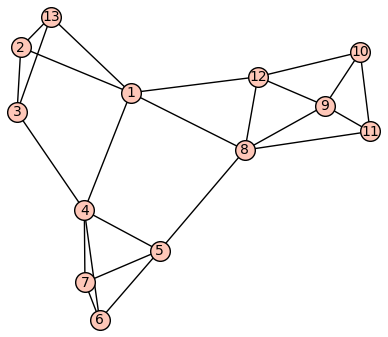

In [41]:
G = Graph([(1, 2), (1, 4), (1, 8), (1, 12), (1, 13), (2, 3), (2, 13), (3, 4), (3, 13), (4, 5), (4, 6),(4, 7), (5, 6), (5, 7), (5, 8),(6, 7), (8, 9), (8, 11), (8, 12), (9, 10), (9, 11), (9, 12),(10, 11), (10, 12)])
G.show()

In [42]:
for u, v, l in G.edges():
	G.set_edge_label(u, v, f'({u},{v})')

In [43]:
tric1 = TriconnectivitySPQR_Aux(G)

In [44]:
print(tric1.comp_list_new1)

[[(8, 9, '(8,9)'), (9, 10, '(9,10)'), (10, 11, '(10,11)'), (9, 11, '(9,11)'), (8, 11, '(8,11)'), (10, 12, '(10,12)'), (9, 12, '(9,12)'), (8, 12, 'newVEdge0')], [(8, 12, '(8,12)'), (8, 12, 'newVEdge0'), (8, 12, 'newVEdge1')], [(8, 12, 'newVEdge1'), (1, 12, '(1,12)'), (8, 1, 'newVEdge2')], [(1, 8, '(1,8)'), (8, 1, 'newVEdge2'), (8, 1, 'newVEdge3')], [(5, 8, '(5,8)'), (8, 1, 'newVEdge3'), (5, 1, 'newVEdge4')], [(5, 6, '(5,6)'), (4, 6, '(4,6)'), (6, 7, '(6,7)'), (5, 7, '(5,7)'), (4, 7, '(4,7)'), (5, 4, 'newVEdge5')], [(5, 4, 'newVEdge5'), (4, 5, 'newVEdge6'), (4, 5, '(4,5)')], [(4, 5, 'newVEdge6'), (5, 1, 'newVEdge4'), (4, 1, 'newVEdge7')], [(1, 4, '(1,4)'), (4, 1, 'newVEdge7'), (4, 1, 'newVEdge8')], [(3, 4, '(3,4)'), (4, 1, 'newVEdge8'), (3, 1, 'newVEdge9')], [(1, 13, '(1,13)'), (2, 13, '(2,13)'), (3, 13, '(3,13)'), (3, 1, 'newVEdge9'), (2, 3, '(2,3)'), (1, 2, '(1,2)')]]


In [45]:
tric1.type1

[(1, 8), (1, 5), (4, 5), (1, 4), (1, 3)]

In [46]:
tric1.type2

[(8, 12)]

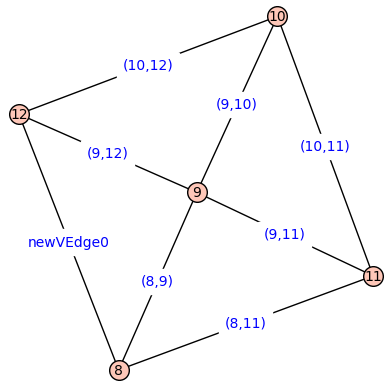

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$10$},x=5.0cm,y=2.4599cm]{v0}
\Vertex[L=\hbox{$11$},x=2.5293cm,y=5.0cm]{v1}
\Vertex[L=\hbox{$12$},x=2.556cm,y=0.0cm]{v2}
\Vertex[L=\hbox{$8$},x=0.0cm,y=2.6783cm]{v3}
\Vertex[L=\hbox{$9$},x=2.5743cm,y=2.5958cm]{v4}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v4)(v0)
\Edge[](v3)(v1)
\Edge[](v4)(v1)
\Edge[](v3)(v2)
\Edge[](v4)(v2)
\Edge[](v3)(v4)
%
\end{tikzpicture}


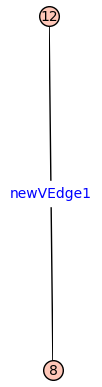

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$12$},x=5.0cm,y=0.0cm]{v0}
\Vertex[L=\hbox{$8$},x=0.0cm,y=5.0cm]{v1}
%
\Edge[](v1)(v0)
%
\end{tikzpicture}


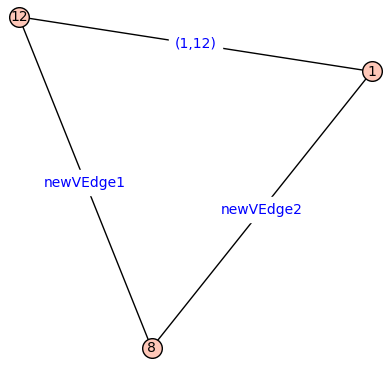

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$12$},x=0.0cm,y=4.5901cm]{v0}
\Vertex[L=\hbox{$1$},x=5.0cm,y=5.0cm]{v1}
\Vertex[L=\hbox{$8$},x=2.7964cm,y=0.0cm]{v2}
%
\Edge[](v1)(v0)
\Edge[](v2)(v0)
\Edge[](v1)(v2)
%
\end{tikzpicture}


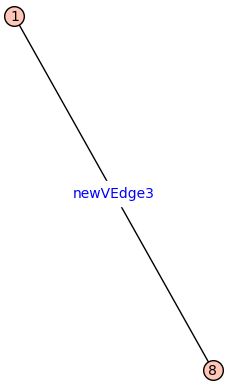

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=5.0cm,y=0.0cm]{v0}
\Vertex[L=\hbox{$8$},x=0.0cm,y=5.0cm]{v1}
%
\Edge[](v0)(v1)
%
\end{tikzpicture}


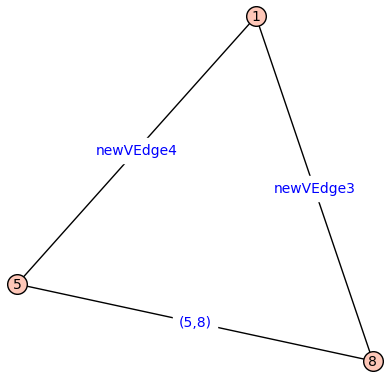

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=0.0cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$5$},x=2.3615cm,y=0.0cm]{v1}
\Vertex[L=\hbox{$8$},x=5.0cm,y=4.8054cm]{v2}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v1)(v2)
%
\end{tikzpicture}


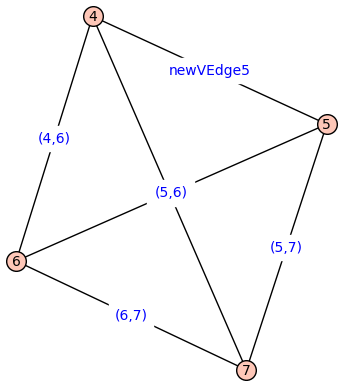

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$4$},x=2.8415cm,y=0.0cm]{v0}
\Vertex[L=\hbox{$5$},x=0.0cm,y=2.2269cm]{v1}
\Vertex[L=\hbox{$6$},x=5.0cm,y=2.7695cm]{v2}
\Vertex[L=\hbox{$7$},x=2.157cm,y=5.0cm]{v3}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v0)(v3)
\Edge[](v1)(v2)
\Edge[](v1)(v3)
\Edge[](v2)(v3)
%
\end{tikzpicture}


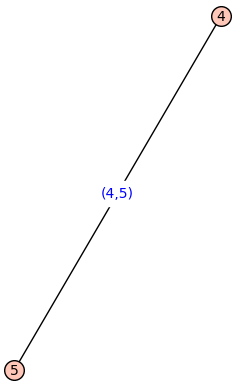

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$4$},x=0.0cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$5$},x=5.0cm,y=0.0cm]{v1}
%
\Edge[](v0)(v1)
%
\end{tikzpicture}


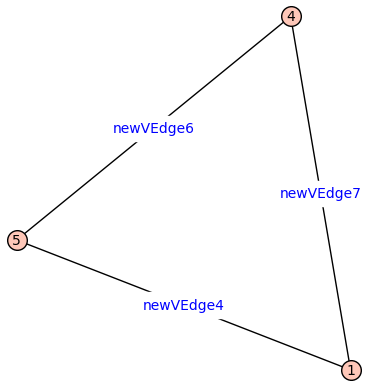

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=2.7977cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$4$},x=5.0cm,y=0.0cm]{v1}
\Vertex[L=\hbox{$5$},x=0.0cm,y=0.4096cm]{v2}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v1)(v2)
%
\end{tikzpicture}


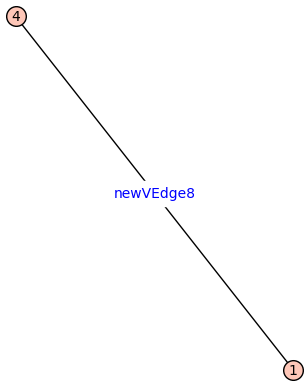

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=5.0cm,y=0.0cm]{v0}
\Vertex[L=\hbox{$4$},x=0.0cm,y=5.0cm]{v1}
%
\Edge[](v0)(v1)
%
\end{tikzpicture}


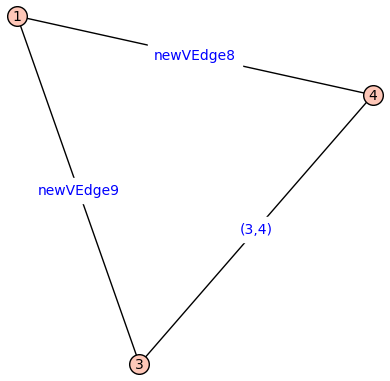

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=2.5076cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$3$},x=5.0cm,y=0.0cm]{v1}
\Vertex[L=\hbox{$4$},x=0.0cm,y=0.0748cm]{v2}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v1)(v2)
%
\end{tikzpicture}


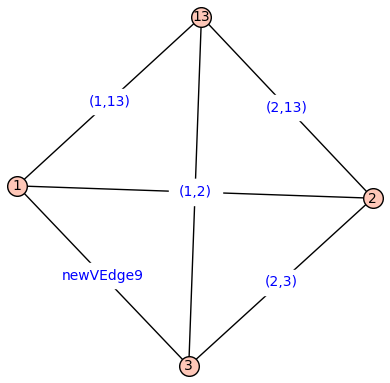

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$13$},x=3.8206cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$1$},x=1.1851cm,y=0.0cm]{v1}
\Vertex[L=\hbox{$2$},x=0.0cm,y=3.7957cm]{v2}
\Vertex[L=\hbox{$3$},x=5.0cm,y=1.2011cm]{v3}
%
\Edge[](v1)(v0)
\Edge[](v2)(v0)
\Edge[](v3)(v0)
\Edge[](v1)(v2)
\Edge[](v1)(v3)
\Edge[](v2)(v3)
%
\end{tikzpicture}


In [47]:
for componente in tric1.comp_list_new1:
	grafo = Graph(componente)
	grafo.graphplot(edge_labels=True).show()
	opts = grafo.latex_options()
	grafo.set_latex_options(tkz_style='Normal')
	check_tkz_graph()
	print(opts.tkz_picture())
	#print(latex(grafo))

In [48]:
G2 = {
	1:[2, 4],
	2:[1, 3, 5, 6],
	3:[2, 4, 5, 6, 7],
	4:[1, 3, 7],
	5:[2, 3, 6],
	6:[2, 3, 5],
	7:[3, 4],
}

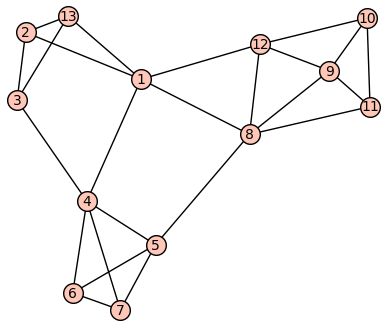

In [49]:
G = Graph([(1, 2), (1, 4), (1, 8), (1, 12), (1, 13), (2, 3), (2, 13), (3, 4), (3, 13), (4, 5), (4, 6),(4, 7), (5, 6), (5, 7), (5, 8),(6, 7), (8, 9), (8, 11), (8, 12), (9, 10), (9, 11), (9, 12),(10, 11), (10, 12)])
G.show()

In [50]:
tric = TriconnectivitySPQR(G)
T = tric.get_spqr_tree()
G.is_isomorphic(spqr_tree_to_graph(T))

True

In [51]:
tric.print_triconnected_components()

Triconnected: [(8, 9, None), (9, 12, None), (9, 11, None), (8, 11, None), (10, 11, None), (9, 10, None), (10, 12, None), (8, 12, 'newVEdge0')]
Bond: [(8, 12, None), (8, 12, 'newVEdge0'), (8, 12, 'newVEdge1')]
Triconnected: [(5, 6, None), (4, 6, None), (6, 7, None), (5, 7, None), (4, 7, None), (5, 4, 'newVEdge2')]
Bond: [(5, 4, 'newVEdge2'), (4, 5, 'newVEdge3'), (4, 5, None)]
Polygon: [(4, 5, 'newVEdge3'), (5, 8, None), (1, 4, 'newVEdge7'), (1, 8, 'newVEdge8')]
Triconnected: [(1, 2, None), (2, 13, None), (1, 13, None), (3, 13, None), (2, 3, None), (1, 3, 'newVEdge5')]
Polygon: [(1, 3, 'newVEdge5'), (3, 4, None), (1, 4, 'newVEdge6')]
Bond: [(1, 4, None), (1, 4, 'newVEdge6'), (1, 4, 'newVEdge7')]
Bond: [(1, 8, None), (1, 8, 'newVEdge8'), (1, 8, 'newVEdge9')]
Polygon: [(8, 12, 'newVEdge1'), (1, 8, 'newVEdge9'), (1, 12, None)]


In [52]:
tric.get_triconnected_components()

[('Triconnected',
  [(8, 9, None),
   (9, 12, None),
   (9, 11, None),
   (8, 11, None),
   (10, 11, None),
   (9, 10, None),
   (10, 12, None),
   (8, 12, 'newVEdge0')]),
 ('Bond', [(8, 12, None), (8, 12, 'newVEdge0'), (8, 12, 'newVEdge1')]),
 ('Triconnected',
  [(5, 6, None),
   (4, 6, None),
   (6, 7, None),
   (5, 7, None),
   (4, 7, None),
   (5, 4, 'newVEdge2')]),
 ('Bond', [(5, 4, 'newVEdge2'), (4, 5, 'newVEdge3'), (4, 5, None)]),
 ('Polygon',
  [(4, 5, 'newVEdge3'),
   (5, 8, None),
   (1, 4, 'newVEdge7'),
   (1, 8, 'newVEdge8')]),
 ('Triconnected',
  [(1, 2, None),
   (2, 13, None),
   (1, 13, None),
   (3, 13, None),
   (2, 3, None),
   (1, 3, 'newVEdge5')]),
 ('Polygon', [(1, 3, 'newVEdge5'), (3, 4, None), (1, 4, 'newVEdge6')]),
 ('Bond', [(1, 4, None), (1, 4, 'newVEdge6'), (1, 4, 'newVEdge7')]),
 ('Bond', [(1, 8, None), (1, 8, 'newVEdge8'), (1, 8, 'newVEdge9')]),
 ('Polygon', [(8, 12, 'newVEdge1'), (1, 8, 'newVEdge9'), (1, 12, None)])]

In [53]:
componentes = tric.get_triconnected_components()

In [54]:
opts = G.latex_options()
G.set_latex_options(tkz_style='Art')

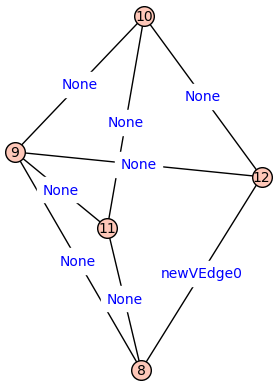

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$12$},x=0.7073cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$11$},x=4.3511cm,y=0.0cm]{v1}
\Vertex[L=\hbox{$10$},x=5.0cm,y=4.3664cm]{v2}
\Vertex[L=\hbox{$8$},x=0.0cm,y=0.6547cm]{v3}
\Vertex[L=\hbox{$9$},x=2.505cm,y=2.3864cm]{v4}
%
\Edge[](v2)(v0)
\Edge[](v3)(v0)
\Edge[](v4)(v0)
\Edge[](v2)(v1)
\Edge[](v3)(v1)
\Edge[](v4)(v1)
\Edge[](v4)(v2)
\Edge[](v3)(v4)
%
\end{tikzpicture}


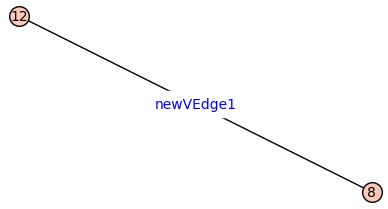

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$12$},x=5.0cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$8$},x=0.0cm,y=0.0cm]{v1}
%
\Edge[](v1)(v0)
%
\end{tikzpicture}


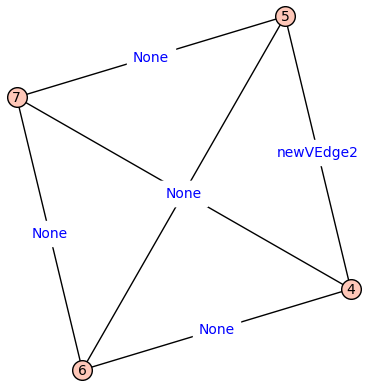

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$4$},x=2.1262cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$5$},x=0.0cm,y=2.0917cm]{v1}
\Vertex[L=\hbox{$6$},x=5.0cm,y=2.9084cm]{v2}
\Vertex[L=\hbox{$7$},x=2.8737cm,y=0.0cm]{v3}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v0)(v3)
\Edge[](v1)(v2)
\Edge[](v1)(v3)
\Edge[](v2)(v3)
%
\end{tikzpicture}


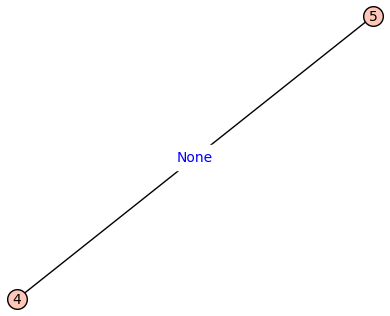

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$4$},x=5.0cm,y=0.0cm]{v0}
\Vertex[L=\hbox{$5$},x=0.0cm,y=5.0cm]{v1}
%
\Edge[](v0)(v1)
%
\end{tikzpicture}


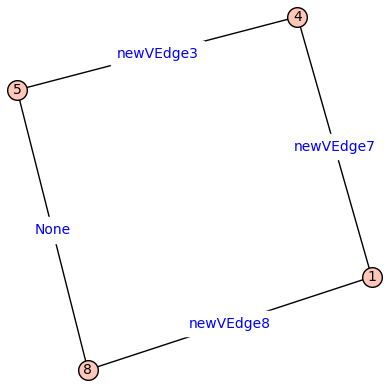

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=0.0cm,y=3.1433cm]{v0}
\Vertex[L=\hbox{$4$},x=1.9087cm,y=0.0cm]{v1}
\Vertex[L=\hbox{$5$},x=5.0cm,y=1.8567cm]{v2}
\Vertex[L=\hbox{$8$},x=3.0913cm,y=5.0cm]{v3}
%
\Edge[](v0)(v1)
\Edge[](v0)(v3)
\Edge[](v1)(v2)
\Edge[](v2)(v3)
%
\end{tikzpicture}


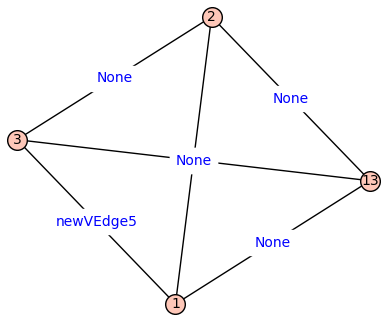

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$13$},x=3.8101cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$1$},x=1.4304cm,y=0.0cm]{v1}
\Vertex[L=\hbox{$2$},x=5.0cm,y=1.7491cm]{v2}
\Vertex[L=\hbox{$3$},x=0.0cm,y=3.4288cm]{v3}
%
\Edge[](v1)(v0)
\Edge[](v2)(v0)
\Edge[](v3)(v0)
\Edge[](v1)(v2)
\Edge[](v1)(v3)
\Edge[](v2)(v3)
%
\end{tikzpicture}


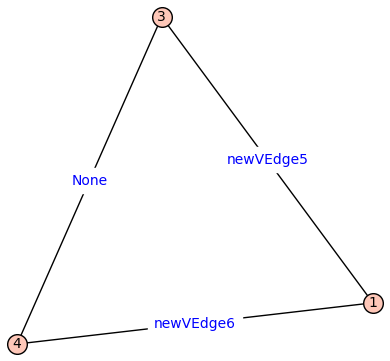

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=0.0cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$3$},x=5.0cm,y=2.5499cm]{v1}
\Vertex[L=\hbox{$4$},x=0.0709cm,y=0.0cm]{v2}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v1)(v2)
%
\end{tikzpicture}


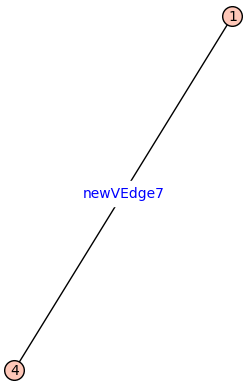

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=5.0cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$4$},x=0.0cm,y=0.0cm]{v1}
%
\Edge[](v0)(v1)
%
\end{tikzpicture}


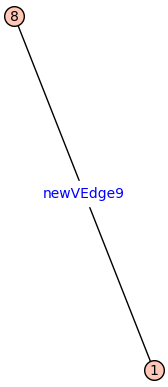

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=5.0cm,y=0.0cm]{v0}
\Vertex[L=\hbox{$8$},x=0.0cm,y=5.0cm]{v1}
%
\Edge[](v0)(v1)
%
\end{tikzpicture}


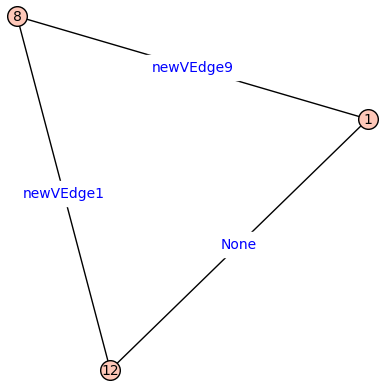

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$12$},x=0.0cm,y=2.1544cm]{v0}
\Vertex[L=\hbox{$1$},x=5.0cm,y=0.0cm]{v1}
\Vertex[L=\hbox{$8$},x=4.5278cm,y=5.0cm]{v2}
%
\Edge[](v1)(v0)
\Edge[](v2)(v0)
\Edge[](v1)(v2)
%
\end{tikzpicture}


In [55]:
for componente in componentes:
	grafo = Graph(componente[1])
	grafo.graphplot(edge_labels=True).show()
	opts = grafo.latex_options()
	grafo.set_latex_options(tkz_style='Normal')
	check_tkz_graph()
	print(opts.tkz_picture())
	#print(latex(grafo))

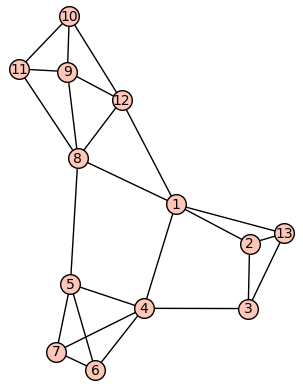

In [56]:
G2 = {
	1: [2, 4],
	2: [1, 3, 5, 6],
	3: [2, 4, 5, 6, 7],
	4: [1, 3, 7],
	5: [2, 3, 6],
	6: [2, 3, 5],
	7: [3, 4],
}
G = Graph(
	[(1, 2), (1, 4), (1, 8), (1, 12), (1, 13), (2, 3), (2, 13), (3, 4), (3, 13), (4, 5), (4, 6), (4, 7), (5, 6), (5, 7),
	 (5, 8), (6, 7), (8, 9), (8, 11), (8, 12), (9, 10), (9, 11), (9, 12), (10, 11), (10, 12)])
G.show()

In [57]:
G12 = Graph(G2)

In [58]:
for u, v, l in G12.edges():
	G12.set_edge_label(u, v, f'({u},{v})')

In [59]:
tric12 = TriconnectivitySPQR_Aux(G12)
print(tric12.comp_list_new1)

[[(4, 7, '(4,7)'), (3, 7, '(3,7)'), (4, 3, 'newVEdge0')], [(4, 3, 'newVEdge0'), (3, 4, 'newVEdge1'), (3, 4, '(3,4)')], [(3, 4, 'newVEdge1'), (1, 4, '(1,4)'), (3, 1, 'newVEdge2')], [(3, 5, '(3,5)'), (2, 5, '(2,5)'), (5, 6, '(5,6)'), (3, 6, '(3,6)'), (2, 6, '(2,6)'), (3, 2, 'newVEdge3')], [(3, 2, 'newVEdge3'), (2, 3, 'newVEdge4'), (2, 3, '(2,3)')], [(3, 1, 'newVEdge2'), (2, 3, 'newVEdge4'), (1, 2, '(1,2)')]]


In [60]:
tric12.type2

[]

In [61]:
tric12.type1

[(3, 4), (1, 3), (2, 3)]

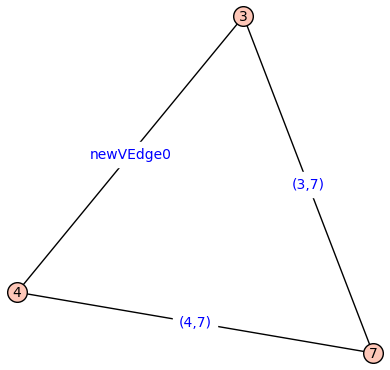

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$3$},x=0.1084cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$4$},x=5.0cm,y=2.4231cm]{v1}
\Vertex[L=\hbox{$7$},x=0.0cm,y=0.0cm]{v2}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v1)(v2)
%
\end{tikzpicture}


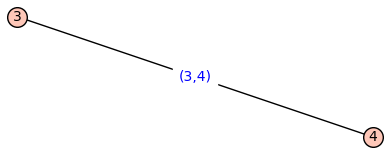

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$3$},x=5.0cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$4$},x=0.0cm,y=0.0cm]{v1}
%
\Edge[](v0)(v1)
%
\end{tikzpicture}


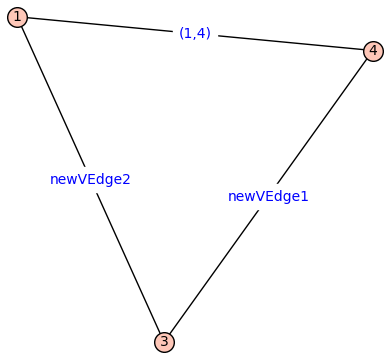

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=5.0cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$3$},x=4.4682cm,y=0.0cm]{v1}
\Vertex[L=\hbox{$4$},x=0.0cm,y=2.8947cm]{v2}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v1)(v2)
%
\end{tikzpicture}


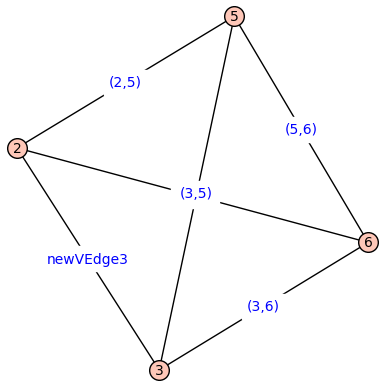

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$2$},x=4.5994cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$3$},x=0.0cm,y=4.7212cm]{v1}
\Vertex[L=\hbox{$5$},x=0.4011cm,y=0.0cm]{v2}
\Vertex[L=\hbox{$6$},x=5.0cm,y=0.2777cm]{v3}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v0)(v3)
\Edge[](v1)(v2)
\Edge[](v1)(v3)
\Edge[](v2)(v3)
%
\end{tikzpicture}


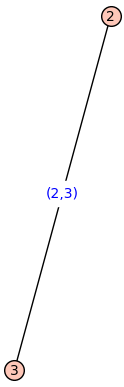

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$2$},x=5.0cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$3$},x=0.0cm,y=0.0cm]{v1}
%
\Edge[](v0)(v1)
%
\end{tikzpicture}


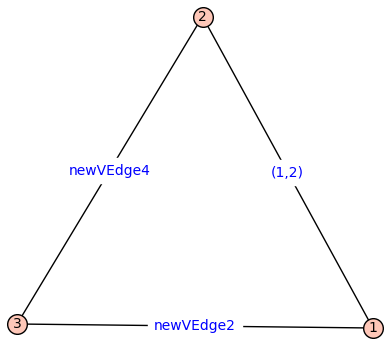

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=3.082cm,y=0.0cm]{v0}
\Vertex[L=\hbox{$2$},x=5.0cm,y=5.0cm]{v1}
\Vertex[L=\hbox{$3$},x=0.0cm,y=4.2201cm]{v2}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v1)(v2)
%
\end{tikzpicture}


In [62]:
for componente in tric12.comp_list_new1:
	grafo = Graph(componente)
	grafo.graphplot(edge_labels=True).show()
	opts = grafo.latex_options()
	grafo.set_latex_options(tkz_style='Normal')
	check_tkz_graph()
	print(opts.tkz_picture())
	#check_tkz_graph()
	#print(latex(grafo))

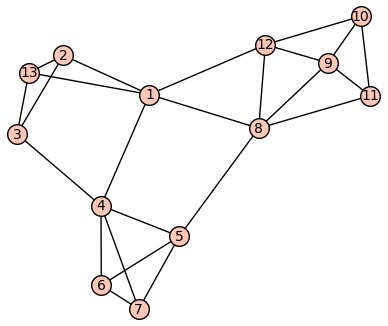

In [63]:
G3 = {
	1: [2, 3, 4],
	2: [1, 3, 4],
	3: [1, 2, 5, 6],
	4: [1, 2, 5, 6],
	5: [3, 4, 6],
	6: [3, 4, 5]
}
G = Graph(
	[(1, 2), (1, 4), (1, 8), (1, 12), (1, 13), (2, 3), (2, 13), (3, 4), (3, 13), (4, 5), (4, 6), (4, 7), (5, 6), (5, 7),
	 (5, 8), (6, 7), (8, 9), (8, 11), (8, 12), (9, 10), (9, 11), (9, 12), (10, 11), (10, 12)])
G.show()

In [64]:
tric = TriconnectivitySPQR(G12)
T = tric.get_spqr_tree()
G12.is_isomorphic(spqr_tree_to_graph(T))

True

In [65]:
tric.print_triconnected_components()

Polygon: [(4, 7, '(4,7)'), (3, 7, '(3,7)'), (4, 3, 'newVEdge0')]
Bond: [(4, 3, 'newVEdge0'), (3, 4, 'newVEdge1'), (3, 4, '(3,4)')]
Polygon: [(3, 4, 'newVEdge1'), (1, 4, '(1,4)'), (2, 3, 'newVEdge4'), (1, 2, '(1,2)')]
Triconnected: [(3, 5, '(3,5)'), (2, 5, '(2,5)'), (5, 6, '(5,6)'), (3, 6, '(3,6)'), (2, 6, '(2,6)'), (3, 2, 'newVEdge3')]
Bond: [(3, 2, 'newVEdge3'), (2, 3, 'newVEdge4'), (2, 3, '(2,3)')]


In [66]:
tric.get_triconnected_components()

[('Polygon', [(4, 7, '(4,7)'), (3, 7, '(3,7)'), (4, 3, 'newVEdge0')]),
 ('Bond', [(4, 3, 'newVEdge0'), (3, 4, 'newVEdge1'), (3, 4, '(3,4)')]),
 ('Polygon',
  [(3, 4, 'newVEdge1'),
   (1, 4, '(1,4)'),
   (2, 3, 'newVEdge4'),
   (1, 2, '(1,2)')]),
 ('Triconnected',
  [(3, 5, '(3,5)'),
   (2, 5, '(2,5)'),
   (5, 6, '(5,6)'),
   (3, 6, '(3,6)'),
   (2, 6, '(2,6)'),
   (3, 2, 'newVEdge3')]),
 ('Bond', [(3, 2, 'newVEdge3'), (2, 3, 'newVEdge4'), (2, 3, '(2,3)')])]

In [67]:
componentes = tric.get_triconnected_components()

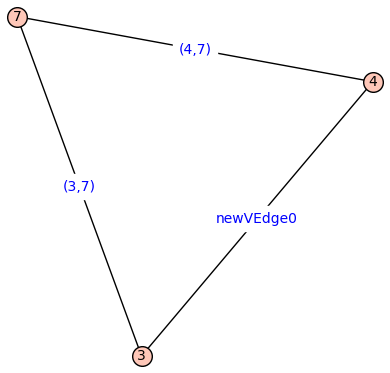

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$3$},x=2.8115cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$4$},x=0.0cm,y=0.426cm]{v1}
\Vertex[L=\hbox{$7$},x=5.0cm,y=0.0cm]{v2}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v1)(v2)
%
\end{tikzpicture}


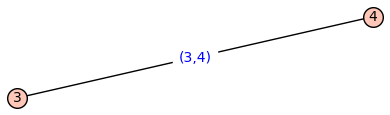

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$3$},x=0.0cm,y=0.0cm]{v0}
\Vertex[L=\hbox{$4$},x=5.0cm,y=5.0cm]{v1}
%
\Edge[](v0)(v1)
%
\end{tikzpicture}


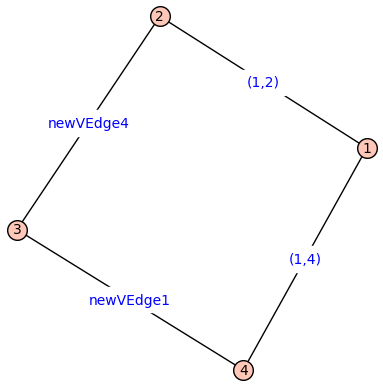

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=5.0cm,y=0.0194cm]{v0}
\Vertex[L=\hbox{$2$},x=4.4056cm,y=5.0cm]{v1}
\Vertex[L=\hbox{$3$},x=0.0cm,y=4.8988cm]{v2}
\Vertex[L=\hbox{$4$},x=0.4515cm,y=0.0cm]{v3}
%
\Edge[](v0)(v1)
\Edge[](v0)(v3)
\Edge[](v1)(v2)
\Edge[](v2)(v3)
%
\end{tikzpicture}


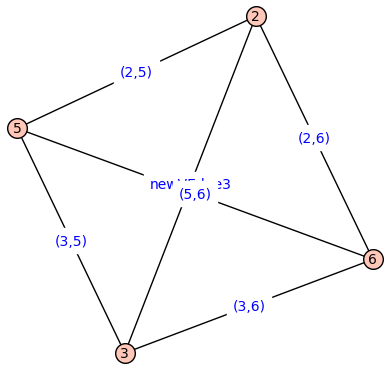

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$2$},x=0.8046cm,y=0.0cm]{v0}
\Vertex[L=\hbox{$3$},x=5.0cm,y=0.9326cm]{v1}
\Vertex[L=\hbox{$5$},x=0.0cm,y=4.0806cm]{v2}
\Vertex[L=\hbox{$6$},x=4.1851cm,y=5.0cm]{v3}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v0)(v3)
\Edge[](v1)(v2)
\Edge[](v1)(v3)
\Edge[](v2)(v3)
%
\end{tikzpicture}


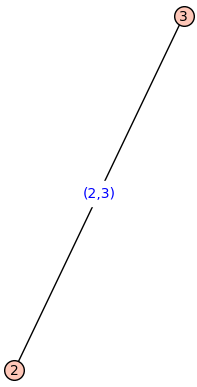

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$2$},x=5.0cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$3$},x=0.0cm,y=0.0cm]{v1}
%
\Edge[](v0)(v1)
%
\end{tikzpicture}


In [68]:
for componente in componentes:
	grafo = Graph(componente[1])
	grafo.graphplot(edge_labels=True).show()
	opts = grafo.latex_options()
	grafo.set_latex_options(tkz_style='Normal')
	check_tkz_graph()
	print(opts.tkz_picture())
	#check_tkz_graph()
	#print(latex(grafo))

In [69]:
G4 = {
	1: [3, 4, 5],
	2: [3, 4, 5],
	3: [1, 2],
	4: [1, 2, 5],
	5: [2, 1, 4]
}

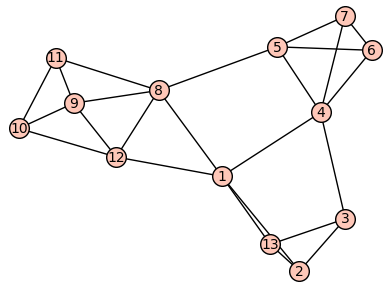

In [70]:
G = Graph(
	[(1, 2), (1, 4), (1, 8), (1, 12), (1, 13), (2, 3), (2, 13), (3, 4), (3, 13), (4, 5), (4, 6), (4, 7), (5, 6), (5, 7),
	 (5, 8), (6, 7), (8, 9), (8, 11), (8, 12), (9, 10), (9, 11), (9, 12), (10, 11), (10, 12)])
G.show()

In [71]:
G22 = Graph(G3)

In [72]:
for u, v, l in G22.edges():
	G22.set_edge_label(u, v, f'({u},{v})')

In [73]:
tric22 = TriconnectivitySPQR_Aux(G22)
print(len(tric22.comp_list_new1))
print(tric22.comp_list_new1)

2
[[(3, 5, '(3,5)'), (4, 5, '(4,5)'), (4, 6, '(4,6)'), (5, 6, '(5,6)'), (3, 6, '(3,6)'), (3, 4, 'newVEdge0')], [(1, 4, '(1,4)'), (2, 4, '(2,4)'), (3, 4, 'newVEdge0'), (1, 3, '(1,3)'), (2, 3, '(2,3)'), (1, 2, '(1,2)')]]


In [74]:
tric22.type1

[]

In [75]:
tric22.type2

[(3, 4)]

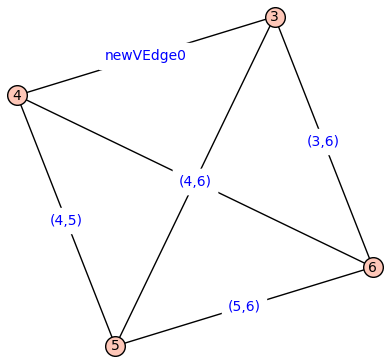

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$3$},x=5.0cm,y=2.1389cm]{v0}
\Vertex[L=\hbox{$4$},x=2.1342cm,y=0.0cm]{v1}
\Vertex[L=\hbox{$5$},x=0.0cm,y=2.8713cm]{v2}
\Vertex[L=\hbox{$6$},x=2.9347cm,y=5.0cm]{v3}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v0)(v3)
\Edge[](v1)(v2)
\Edge[](v1)(v3)
\Edge[](v2)(v3)
%
\end{tikzpicture}


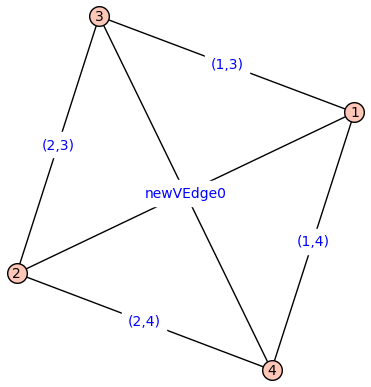

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=3.9119cm,y=0.0cm]{v0}
\Vertex[L=\hbox{$2$},x=5.0cm,y=3.9873cm]{v1}
\Vertex[L=\hbox{$3$},x=1.0876cm,y=5.0cm]{v2}
\Vertex[L=\hbox{$4$},x=0.0cm,y=1.0118cm]{v3}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v0)(v3)
\Edge[](v1)(v2)
\Edge[](v1)(v3)
\Edge[](v2)(v3)
%
\end{tikzpicture}


In [76]:
for componente in tric22.comp_list_new1:
	grafo = Graph(componente)
	grafo.graphplot(edge_labels=True).show()
	opts = grafo.latex_options()
	grafo.set_latex_options(tkz_style='Normal')
	check_tkz_graph()
	print(opts.tkz_picture())
#check_tkz_graph()
#print(latex(grafo))

In [77]:
tric = TriconnectivitySPQR(G22)
T = tric.get_spqr_tree()
G22.is_isomorphic(spqr_tree_to_graph(T))

True

In [78]:
tric.print_triconnected_components()

Triconnected: [(3, 5, '(3,5)'), (4, 5, '(4,5)'), (4, 6, '(4,6)'), (5, 6, '(5,6)'), (3, 6, '(3,6)'), (3, 4, 'newVEdge0')]
Triconnected: [(1, 4, '(1,4)'), (2, 4, '(2,4)'), (3, 4, 'newVEdge0'), (1, 3, '(1,3)'), (2, 3, '(2,3)'), (1, 2, '(1,2)')]


In [79]:
tric.get_triconnected_components()

[('Triconnected',
  [(3, 5, '(3,5)'),
   (4, 5, '(4,5)'),
   (4, 6, '(4,6)'),
   (5, 6, '(5,6)'),
   (3, 6, '(3,6)'),
   (3, 4, 'newVEdge0')]),
 ('Triconnected',
  [(1, 4, '(1,4)'),
   (2, 4, '(2,4)'),
   (3, 4, 'newVEdge0'),
   (1, 3, '(1,3)'),
   (2, 3, '(2,3)'),
   (1, 2, '(1,2)')])]

In [80]:
componentes = tric.get_triconnected_components()

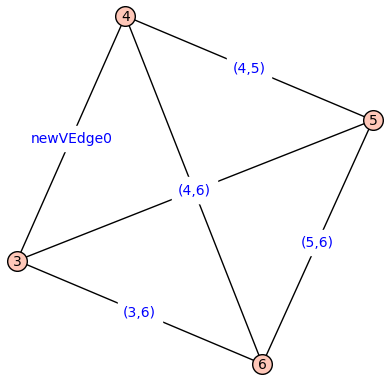

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$3$},x=0.2242cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$4$},x=5.0cm,y=4.762cm]{v1}
\Vertex[L=\hbox{$5$},x=0.0cm,y=0.2443cm]{v2}
\Vertex[L=\hbox{$6$},x=4.7804cm,y=0.0cm]{v3}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v0)(v3)
\Edge[](v1)(v2)
\Edge[](v1)(v3)
\Edge[](v2)(v3)
%
\end{tikzpicture}


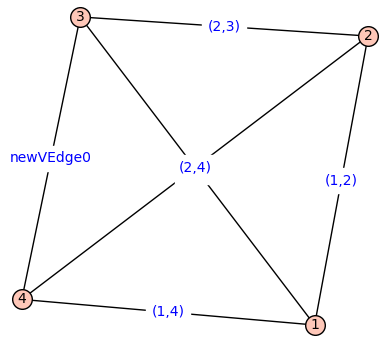

\begin{tikzpicture}
\GraphInit[vstyle=Normal]
%
\Vertex[L=\hbox{$1$},x=2.024cm,y=5.0cm]{v0}
\Vertex[L=\hbox{$2$},x=2.9759cm,y=0.0cm]{v1}
\Vertex[L=\hbox{$3$},x=5.0cm,y=2.9502cm]{v2}
\Vertex[L=\hbox{$4$},x=0.0cm,y=2.0499cm]{v3}
%
\Edge[](v0)(v1)
\Edge[](v0)(v2)
\Edge[](v0)(v3)
\Edge[](v1)(v2)
\Edge[](v1)(v3)
\Edge[](v2)(v3)
%
\end{tikzpicture}


In [81]:
for componente in componentes:
	grafo = Graph(componente[1])
	grafo.graphplot(edge_labels=True).show()
	opts = grafo.latex_options()
	grafo.set_latex_options(tkz_style='Normal')
	check_tkz_graph()
	print(opts.tkz_picture())
	#check_tkz_graph()
	#print(latex(grafo))

In [82]:
G4 = {
	1: [3, 4, 5],
	2: [3, 4, 5],
	3: [1, 2],
	4: [1, 2, 5],
	5: [2, 1, 4]
}
print(G4)

{1: [3, 4, 5], 2: [3, 4, 5], 3: [1, 2], 4: [1, 2, 5], 5: [2, 1, 4]}


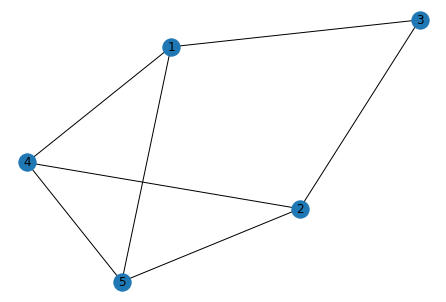

In [83]:
d = nx.Graph(G4)
nx.draw(d, with_labels=True)
plt.savefig('plotgraph3.png', dpi=300, bbox_inches='tight')
plt.show()

In [84]:
grafo = recorridoDepth(G4, 1)
Spanning_Tree, Bactracking_Tree = grafo.dFS()
print("Spanning Tree edges", Spanning_Tree)
#print("Bactracking Tree edges", Bactracking_Tree)

NameError: name 'recorridoDepth' is not defined

In [ ]:
df = grafo.low1_low2()
df

In [ ]:
#print(df.to_latex(index=False))

In [ ]:
aux = auxTricconected(G4, 1)
aux.etiquetado()

In [ ]:
aristas_ordenadas = aux.ordenado()
print(aristas_ordenadas)

In [ ]:
aux.pathfinder(1)

In [ ]:
grafo.dibujar_grafo_recorrido('G5.png')

In [ ]:
G32 = Graph(G4)
for u, v, l in G32.edges():
	G32.set_edge_label(u, v, f'({u},{v})')

In [ ]:
tric32 = TriconnectivitySPQR_Aux(G32)
print(len(tric32.comp_list_new1))
print(tric32.comp_list_new1)

In [ ]:
tric32.type1

In [ ]:
tric32.type2

In [ ]:
for componente in tric32.comp_list_new1:
	grafo = Graph(componente)
	grafo.graphplot(edge_labels=True).show()
	opts = grafo.latex_options()
	grafo.set_latex_options(tkz_style='Normal')
	check_tkz_graph()
	print(opts.tkz_picture())
#check_tkz_graph()
#print(latex(grafo))

In [ ]:
tric = TriconnectivitySPQR(G32)
T = tric.get_spqr_tree()
G22.is_isomorphic(spqr_tree_to_graph(T))

In [ ]:
tric.print_triconnected_components()

In [ ]:
tric.get_triconnected_components()

In [ ]:
componentes = tric.get_triconnected_components()
for componente in componentes:
	grafo = Graph(componente[1])
	grafo.graphplot(edge_labels=True).show()
	opts = grafo.latex_options()
	grafo.set_latex_options(tkz_style='Normal')
	check_tkz_graph()
	print(opts.tkz_picture())
#check_tkz_graph()
#print(latex(grafo))